# <font color='darkblue'>Applied Data Science Project Grupp 21 - FS 2022</font>
# <font color='blue'>Classification Modell zur Fahrzeug-Bilder-Erkennung</font>
<font color="blue">Quellen</font>
<li>flickr_api_example/flickr_example_01.ipynb von Mario Gellrich</li>
<li>https://www.tensorflow.org/tutorials/images/classification</li>
<li>Exercise6-transfer_learning.ipynb von Elena Gavarin</li>
<li>https://keras.io/guides/transfer_learning/</li>

## <font color='blue'>Notebook Preparation</font>
### <font color='blue'>Libraries to install</font>
<li>pip install pandas</li>
<li>pip install numpy</li>
<li>pip install matplotlib.pyplot</li>
<li>pip install tensorflow</li>
<li>pip install PIL</li>
<li>pip install flickrapi</li>


### <font color='blue'>Libraries to import</font>

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pandas as pd
import pathlib
import time
import collections


import PIL
from IPython.display import Image, display
import matplotlib.cm as cm

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

print ("Import Libraries Successfull")

Import Libraries Successfull


### <font color='blue'>Set working directory</font>

In [22]:
#fill in your working directory
path="/Users/andreazkb/Documents/ZHAW/ADS/Projekt/"
os.chdir(path)
os.getcwd()

'/Users/andreazkb/Documents/ZHAW/ADS/Projekt'

## <font color='blue'>Load and prepare data</font>
<font color='blue'>Load the collected images and split into train and validation set. The images are organized in two folders, at the same time those folders give the images their class. </font>

In [34]:
data_dir = os.path.join(os.curdir, 'gruppe21-data/')
BATCH_SIZE = 32
IMG_SIZE = (192, 192)

train_dataset = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            shuffle=True,
                                                            seed=999,
                                                            validation_split=0.20,
                                                            subset = "training")

validation_dataset = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            shuffle=True,
                                                            seed=999,
                                                            validation_split=0.20,
                                                            subset = "validation")

Found 1929 files belonging to 2 classes.
Using 1544 files for training.
Found 1929 files belonging to 2 classes.
Using 385 files for validation.


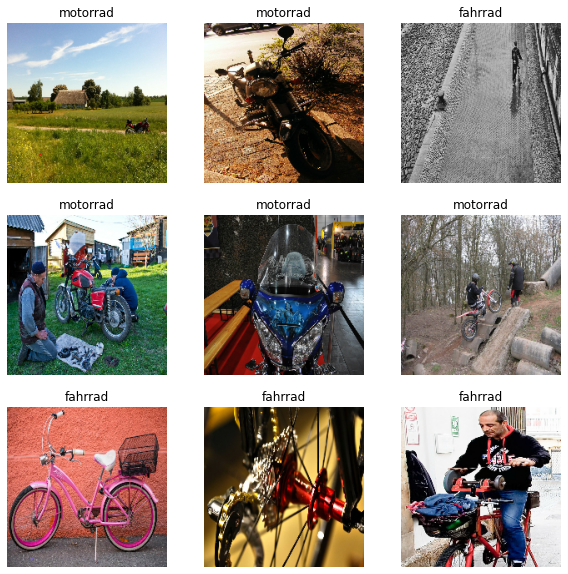

In [36]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [37]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
val_dataset = validation_dataset.skip(val_batches // 5)

In [38]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 13
Number of test batches: 2


<font color='blue'>Improvement of performance of model training. The Autotune function checks the load on runtime and optimizes the distribution of CPU. </font>

In [39]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

<font color='blue'>Insert data augmentation to increase diversity on input and reduce overfitting </font>

In [40]:
with tf.device('/cpu:0'):
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip()
    ])

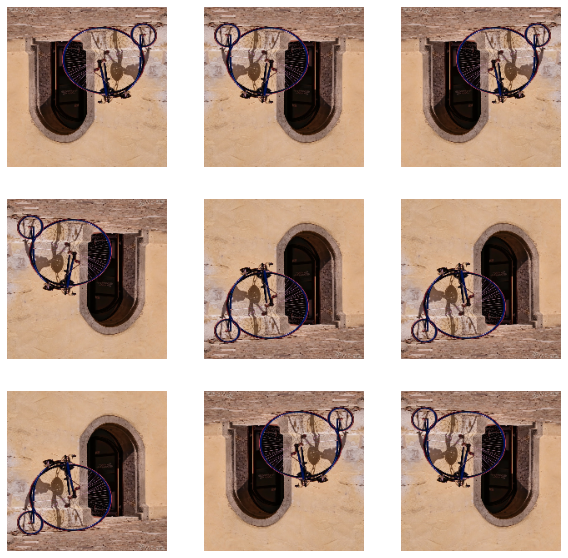

In [41]:
with tf.device('/cpu:0'):
    for image, _ in train_dataset.take(1):
      plt.figure(figsize=(10, 10))
      first_image = image[0]
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

## <font color='blue'>Classification model</font>
<font color='blue'>The use of an existing and pretrained model reduces complexity for classification tasks as well as helps building fast and performant models. </font>
### <font color="blue">Transfer model MobileNetV2</font>
<font color="blue">For this case the MobileNetV2 model is used, since it is specifically trained on image classification. The model is created based on the MobileNet V2, the layers are freezed then to avoid destroying information they contain.</font>

In [42]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [43]:
# Create the base model from the pre-trained model MobileNet V2

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [44]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 1280)


In [45]:
base_model.trainable = False

In [46]:
base_model.summary()

Model: "mobilenetv2_1.00_192"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 96, 96, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 96, 96, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 96, 96, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 24, 24, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 24, 24, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 24, 24, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 24, 24, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 12, 12, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 12, 12, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 12, 12, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 12, 12, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 12, 12, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 12, 12, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 12, 12, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 6, 6, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 6, 6, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 6, 6, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 6, 6, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

<font color="blue">According to the inpput from class (Exercise6-transfer_learning) the following steps are taken with the base model:

<li>Combining the base model with fully connected layers (tf.keras.layers.Dense)</li>
<li>Insert data augmentation as input</li>
<li>Insert preprossessing function</li>
<li>Insert the base model</li>
<li>Add classification head</li>
<li>convert these features into a single prediction per image</li>
</font>

In [47]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x) 
model = tf.keras.Model(inputs, outputs)

In [48]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [49]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 192, 192, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 192, 192, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 192, 192, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_192 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                             

### <font color="blue">Train the Model</font>

In [50]:
initial_epochs = 20

loss0, accuracy0 = model.evaluate(validation_dataset)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
13/13 [==============================] - 5s 309ms/step - loss: 0.8392 - accuracy: 0.4364


In [51]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.84
initial accuracy: 0.44


In [52]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
49/49 [==============================] - 25s 477ms/step - loss: 0.7863 - accuracy: 0.5285 - val_loss: 0.7551 - val_accuracy: 0.5299
Epoch 2/20
49/49 [==============================] - 24s 489ms/step - loss: 0.6879 - accuracy: 0.6049 - val_loss: 0.6752 - val_accuracy: 0.6026
Epoch 3/20
49/49 [==============================] - 25s 498ms/step - loss: 0.6143 - accuracy

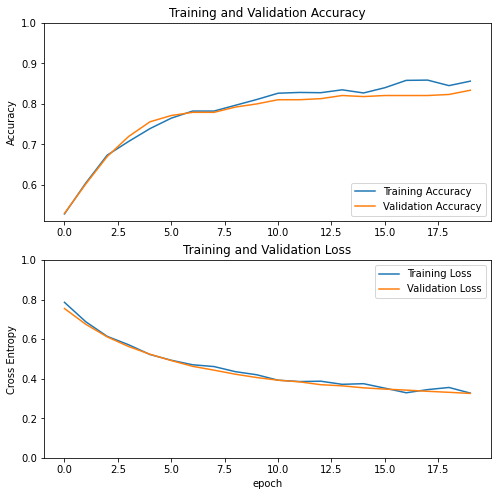

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [54]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

2/2 [==============================] - 1s 332ms/step - loss: 0.3567 - accuracy: 0.8281
Test accuracy : 0.828125


### <font color="blue">Evaluating the Model & Prediction</font>
<font color="blue">With a batch of images we test the model and the predictions</font>

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Predictions:
 [0 0 0 1 1 0 0 0 1 0 1 1 0 1 0 1 1 1 0 1 0 0 0 0 0 0 1 1 1 1 1 1]
Labels:
 [0 0 0 0 1 0 1 1 1 0 1 1 0 1 0 1 1 0 0 1 0 0 1 0 0 0 0 1 1 1 1 1]


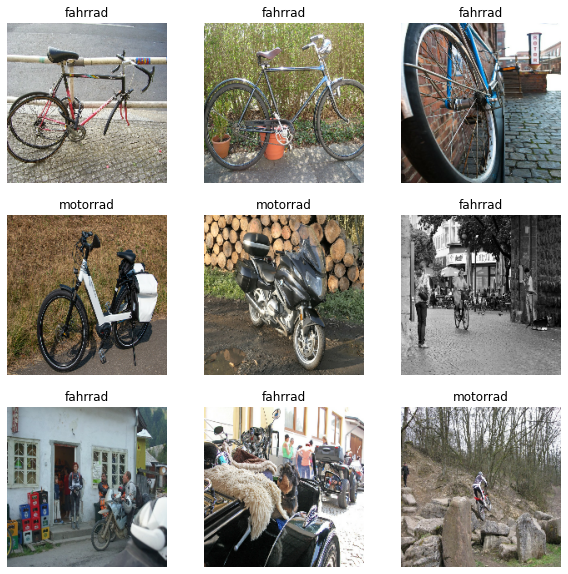

In [55]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")